In [1]:
from openai import OpenAI
import os

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')

In [2]:
question_maker_prompt = """
You are an agent that generates questions from provided text. Your job is to generate a question and provide the relevant sections from the text as references.

Instructions:
1. For each provided text, generate a question that can be answered solely by the facts in the text.
2. Extract all significant facts that answer the generated question.
3. Format the response in JSON format with two fields:
   - 'question': A question directly related to these facts, ensuring it can only be answered using the references provided.
   - 'references': A list of all text sections that answer the generated question. These must be exact copies from the original text and should be whole sentences where possible.

Notes: 
Make the question more specific.
Do not ask a question about multiple topics. 
Do not ask a question with over 5 references.

Example:

Text: "Experiment A: The temperature control test showed that at higher temperatures, the reaction rate increased significantly, resulting in quicker product formation. However, at extremely high temperatures, the reaction yield decreased due to the degradation of reactants.

Experiment B: The pH sensitivity test revealed that the reaction is highly dependent on acidity, with optimal results at a pH of 7. Deviating from this pH level in either direction led to a substantial drop in yield.

Experiment C: In the enzyme activity assay, it was found that the presence of a specific enzyme accelerated the reaction by a factor of 3. The absence of the enzyme, however, led to a sluggish reaction with an extended completion time.

Experiment D: The light exposure trial demonstrated that UV light stimulated the reaction, making it complete in half the time compared to the absence of light. Conversely, prolonged light exposure led to unwanted side reactions that contaminated the final product."

Response: {
  'oath': "I will not use the word 'and' in the question unless it is part of a proper noun. I will also make sure the question is concise.",
  'question': 'What experiments were done in this paper?',
  'references': ['Experiment A: The temperature control test showed that at higher temperatures, the reaction rate increased significantly, resulting in quicker product formation.', 'Experiment B: The pH sensitivity test revealed that the reaction is highly dependent on acidity, with optimal results at a pH of 7.', 'Experiment C: In the enzyme activity assay, it was found that the presence of a specific enzyme accelerated the reaction by a factor of 3.', 'Experiment D: The light exposure trial demonstrated that UV light stimulated the reaction, making it complete in half the time compared to the absence of light.']
}

DO NOT USE THE WORD 'and' IN THE QUESTION UNLESS IT IS PART OF A PROPER NOUN. YOU MUST INCLUDE THE OATH ABOVE IN YOUR RESPONSE.
YOU MUST ALSO NOT REPEAT A QUESTION THAT HAS ALREADY BEEN USED.
"""

In [31]:
test_text = """Experiment A: The temperature control test showed that at higher temperatures, the reaction rate increased significantly, resulting in quicker product formation. However, at extremely high temperatures, the reaction yield decreased due to the degradation of reactants.

Experiment B: The pH sensitivity test revealed that the reaction is highly dependent on acidity, with optimal results at a pH of 7. Deviating from this pH level in either direction led to a substantial drop in yield.

Experiment C: In the enzyme activity assay, it was found that the presence of a specific enzyme accelerated the reaction by a factor of 3. The absence of the enzyme, however, led to a sluggish reaction with an extended completion time.

Experiment D: The light exposure trial demonstrated that UV light stimulated the reaction, making it complete in half the time compared to the absence of light. Conversely, prolonged light exposure led to unwanted side reactions that contaminated the final product.
"""

In [28]:
def text_to_chunked(text):
    chunks = [text[i:i+100] for i in range(0, len(text), 100)]
    chunked_string = ""
    for i, chunk in enumerate(chunks):
        chunked_string += f"<start_chunk_{i}>" + chunk + f"<end_chunk_{i}>"
    return chunked_string

In [34]:
chunked_string = text_to_chunked(test_text)

In [35]:
chunked_string

'<start_chunk_0>Experiment A: The temperature control test showed that at higher temperatures, the reaction rate inc<end_chunk_0><start_chunk_1>reased significantly, resulting in quicker product formation. However, at extremely high temperature<end_chunk_1><start_chunk_2>s, the reaction yield decreased due to the degradation of reactants.\n\nExperiment B: The pH sensitivi<end_chunk_2><start_chunk_3>ty test revealed that the reaction is highly dependent on acidity, with optimal results at a pH of 7<end_chunk_3><start_chunk_4>. Deviating from this pH level in either direction led to a substantial drop in yield.\n\nExperiment C<end_chunk_4><start_chunk_5>: In the enzyme activity assay, it was found that the presence of a specific enzyme accelerated the <end_chunk_5><start_chunk_6>reaction by a factor of 3. The absence of the enzyme, however, led to a sluggish reaction with an ex<end_chunk_6><start_chunk_7>tended completion time.\n\nExperiment D: The light exposure trial demonstrated that 

In [20]:
import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

In [73]:

question_maker_approx_system_prompt = """
You are an agent that generates questions from provided text. Your job is to generate a question and provide the relevant sections from the text as references.

Instructions:
1. For each provided text, generate a question that can be answered solely by the facts in the text.
2. Extract all significant facts that answer the generated question.
3. Format the response in JSON format with two fields:
   - 'question': A question directly related to these facts, ensuring it can only be answered using the references provided.
   - 'references': A list of JSON objects with the following fields: 'content': the text section that answers the question, 'start_chunk': the index of the start chunk, 'end_chunk': the index of the end chunk. These are inclusive indices.

Notes: 
Make the question more specific.
Do not ask a question about multiple topics. 
Do not ask a question with over 5 references.

Example:

Text: {text}

Response: {
  'oath': "I will not use the word 'and' in the question unless it is part of a proper noun. I will also make sure the question is concise.",
  'question': 'What experiments were done in this paper?',
  'references': [{
    'content': 'Experiment A: The temperature control test showed that at higher temperatures, the reaction rate increased significantly, resulting in quicker product formation.',
    'start_chunk': 0,
    'end_chunk': 1,
  }, {
    'content': 'Experiment B: The pH sensitivity test revealed that the reaction is highly dependent on acidity, with optimal results at a pH of 7.',
    'start_chunk': 2,
    'end_chunk': 3,
  }, {
    'content': 'Experiment C: In the enzyme activity assay, it was found that the presence of a specific enzyme accelerated the reaction by a factor of 3.',
    'start_chunk': 4,
    'end_chunk': 6,
  }, {
    'content': 'Experiment D: The light exposure trial demonstrated that UV light stimulated the reaction, making it complete in half the time compared to the absence of light.',
    'start_chunk': 7,
    'end_chunk': 8,
  }]
}

DO NOT USE THE WORD 'and' IN THE QUESTION UNLESS IT IS PART OF A PROPER NOUN. YOU MUST INCLUDE THE OATH ABOVE IN YOUR RESPONSE.
YOU MUST ALSO NOT REPEAT A QUESTION THAT HAS ALREADY BEEN USED.
""".replace("{text}", chunked_string)

In [72]:
print(chunked_string)

<start_chunk_0>Experiment A: The temperature control test showed that at higher temperatures, the reaction rate inc<end_chunk_0><start_chunk_1>reased significantly, resulting in quicker product formation. However, at extremely high temperature<end_chunk_1><start_chunk_2>s, the reaction yield decreased due to the degradation of reactants.

Experiment B: The pH sensitivi<end_chunk_2><start_chunk_3>ty test revealed that the reaction is highly dependent on acidity, with optimal results at a pH of 7<end_chunk_3><start_chunk_4>. Deviating from this pH level in either direction led to a substantial drop in yield.

Experiment C<end_chunk_4><start_chunk_5>: In the enzyme activity assay, it was found that the presence of a specific enzyme accelerated the <end_chunk_5><start_chunk_6>reaction by a factor of 3. The absence of the enzyme, however, led to a sluggish reaction with an ex<end_chunk_6><start_chunk_7>tended completion time.

Experiment D: The light exposure trial demonstrated that UV ligh

In [101]:
test = [1,2,3]

print(test[:100])

[1, 2, 3]


In [92]:
question_maker_approx_user_prompt = """Text: {document}

The following questions have already been used. Do not repeat them: {prev_questions_str}

Do not repeat the above questions. Make your next question unique. Respond with references and a question in JSON. The references must contain the exact text that answers the question and the start_chunk and end_chunk. DO NOT USE THE WORD 'and' IN THE QUESTION UNLESS IT IS PART OF A PROPER NOUN."""

In [70]:
class RecursiveTextSplitter:
    def __init__(self, chunk_length):
        self.chunk_length = chunk_length

    def split_text(self, text):
        if len(text) <= self.chunk_length:
            return [text]

        chunks = []
        start = 0
        while start < len(text):
            end = start + self.chunk_length
            chunk = text[start:end]
            if end < len(text):
                # Find the last space within the chunk to avoid splitting a word
                space_index = chunk.rfind(' ')
                if space_index != -1:
                    end = start + space_index + 1  # Include the space in the chunk
                    chunk = text[start:end]
            chunks.append(chunk)
            start = end  # Move start to end to continue splitting

        return chunks

# Usage example
splitter = RecursiveTextSplitter(chunk_length=50)
text = "This is a long text that needs to be split into smaller chunks. Each chunk should not exceed the specified length."
chunks = splitter.split_text(text)
for i, chunk in enumerate(chunks):
    print(f"Chunk {i + 1}: |{chunk}|")


Chunk 1: |This is a long text that needs to be split into |
Chunk 2: |smaller chunks. Each chunk should not exceed the |
Chunk 3: |specified length.|


In [112]:
import random
import json

def _tag_text(text):
    chunk_length = 100
    chunks = []
    tag_indexes = [0]
    start = 0
    while start < len(text):
        end = start + chunk_length
        chunk = text[start:end]
        if end < len(text):
            # Find the last space within the chunk to avoid splitting a word
            space_index = chunk.rfind(' ')
            if space_index != -1:
                end = start + space_index + 1  # Include the space in the chunk
                chunk = text[start:end]
        chunks.append(chunk)
        tag_indexes.append(end)
        start = end  # Move start to end to continue splitting

    tagged_text = ""
    for i, chunk in enumerate(chunks):
        tagged_text += f"<start_chunk_{i}>" + chunk + f"<end_chunk_{i}>"

    return tagged_text, tag_indexes

client = OpenAI(api_key=OPENAI_API_KEY)

# def _extract_question_and_references(self, corpus, document_length=4000, prev_questions=[]):
def _extract_question_and_references(corpus, document_length=4000, prev_questions=[]):
    if len(corpus) > document_length:
        start_index = random.randint(0, len(corpus) - document_length)
        document = corpus[start_index : start_index + document_length]
    else:
        start_index = 0
        document = corpus
    
    if prev_questions is not None:
        if len(prev_questions) > 20:
            questions_sample = random.sample(prev_questions, 20)
            prev_questions_str = '\n'.join(questions_sample)
        else:
            prev_questions_str = '\n'.join(prev_questions)
    else:
        prev_questions_str = ""

    tagged_text, tag_indexes = _tag_text(document)

    completion = client.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        max_tokens=600,
        messages=[
            {"role": "system", "content": question_maker_approx_system_prompt},
            {"role": "user", "content": question_maker_approx_user_prompt.replace("{document}", tagged_text).replace("{prev_questions_str}", prev_questions_str)}
        ]
    )
    
    json_response = json.loads(completion.choices[0].message.content)

    print(json_response)
    
    try:
        text_references = json_response['references']
    except KeyError:
        raise ValueError("The response does not contain a 'references' field.")
    try:
        question = json_response['question']
    except KeyError:
        raise ValueError("The response does not contain a 'question' field.")

    references = []
    for reference in text_references:
        reference_keys = list(reference.keys())

        if len(reference_keys) != 3:
            raise ValueError(f"Each reference must have exactly 3 keys: 'content', 'start_chunk', and 'end_chunk'. Got keys: {reference_keys}")

        if 'end_chunk' not in reference_keys:
            reference_keys.remove('content')
            reference_keys.remove('start_chunk')
            end_chunk_key = reference_keys[0]
            end_index = start_index + tag_indexes[reference[end_chunk_key]+1]
        else:
            end_index = start_index + tag_indexes[reference['end_chunk']+1]

        start_index = start_index + tag_indexes[reference['start_chunk']]
        references.append((corpus[start_index:end_index], start_index, end_index))
    
    return question, references

In [113]:
text = """On glancing over my notes of the seventy odd cases in which I have
during the last eight years studied the methods of my friend Sherlock
Holmes, I find many tragic, some comic, a large number merely strange,
but none commonplace; for, working as he did rather for the love of his
art than for the acquirement of wealth, he refused to associate himself
with any investigation which did not tend towards the unusual, and even
the fantastic. Of all these varied cases, however, I cannot recall any
which presented more singular features than that which was associated
with the well-known Surrey family of the Roylotts of Stoke Moran. The
events in question occurred in the early days of my association with
Holmes, when we were sharing rooms as bachelors in Baker Street. It is
possible that I might have placed them upon record before, but a
promise of secrecy was made at the time, from which I have only been
freed during the last month by the untimely death of the lady to whom
the pledge was given. It is perhaps as well that the facts should now
come to light, for I have reasons to know that there are widespread
rumours as to the death of Dr. Grimesby Roylott which tend to make the
matter even more terrible than the truth."""

text = text.replace("\n", " ")

tagged_text, _ = _tag_text(text)
print(tagged_text)

<start_chunk_0>On glancing over my notes of the seventy odd cases in which I have during the last eight years <end_chunk_0><start_chunk_1>studied the methods of my friend Sherlock Holmes, I find many tragic, some comic, a large number <end_chunk_1><start_chunk_2>merely strange, but none commonplace; for, working as he did rather for the love of his art than <end_chunk_2><start_chunk_3>for the acquirement of wealth, he refused to associate himself with any investigation which did not <end_chunk_3><start_chunk_4>tend towards the unusual, and even the fantastic. Of all these varied cases, however, I cannot <end_chunk_4><start_chunk_5>recall any which presented more singular features than that which was associated with the <end_chunk_5><start_chunk_6>well-known Surrey family of the Roylotts of Stoke Moran. The events in question occurred in the <end_chunk_6><start_chunk_7>early days of my association with Holmes, when we were sharing rooms as bachelors in Baker Street. <end_chunk_7><start_

In [114]:
formatted_text = ""
line_length = 90
current_length = 0

for word in tagged_text.split():
    if current_length + len(word) + 1 > line_length:
        formatted_text += "\n"
        current_length = 0
    formatted_text += word + " "
    current_length += len(word) + 1

print(formatted_text.strip())


<start_chunk_0>On glancing over my notes of the seventy odd cases in which I have during 
the last eight years <end_chunk_0><start_chunk_1>studied the methods of my friend 
Sherlock Holmes, I find many tragic, some comic, a large number 
<end_chunk_1><start_chunk_2>merely strange, but none commonplace; for, working as he did 
rather for the love of his art than <end_chunk_2><start_chunk_3>for the acquirement of 
wealth, he refused to associate himself with any investigation which did not 
<end_chunk_3><start_chunk_4>tend towards the unusual, and even the fantastic. Of all 
these varied cases, however, I cannot <end_chunk_4><start_chunk_5>recall any which 
presented more singular features than that which was associated with the 
<end_chunk_5><start_chunk_6>well-known Surrey family of the Roylotts of Stoke Moran. The 
events in question occurred in the <end_chunk_6><start_chunk_7>early days of my 
association with Holmes, when we were sharing rooms as bachelors in Baker Street. 
<end_chu

In [120]:
import anthropic
import os

ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_CHROMA_API_KEY')

class AnthropicClient:
    def __init__(self, api_key):
        self.client = anthropic.Anthropic(api_key=api_key)

    def create_message(self, system_prompt, messages, max_tokens=1000):
        message = self.client.messages.create(
            model="claude-3-5-sonnet-20240620",
            max_tokens=max_tokens,
            temperature=0.0,
            system=system_prompt,
            messages=messages
        )
        return message.content[0].text
    
client = AnthropicClient(api_key=ANTHROPIC_API_KEY)

message = client.create_message("You are role playing as al capone, the famous chicago gansta. Engage with the user who is role playing as a newly arrived underdog.", [{
    "role": "user",
    "content": "What is your favorite food?"
}])

In [123]:
print(message[0].text)

As Al Capone, I'd say my favorite food is a good Italian meal, ya see? Nothing beats a plate of my mama's homemade spaghetti and meatballs, with a nice glass of red wine on the side. But let me tell you, kid, in this business, it ain't always about what you like to eat. Sometimes it's about who you're eating with and what deals are going down at the table. Now, what brings a fresh face like you to my territory? You looking to make a name for yourself in Chicago?


In [99]:
with open("/Users/brandon/Desktop/MonteIntelligence/corpora/sherlock_holmes.txt", "r") as file:
    corpus = file.read()

question, references = _extract_question_and_references(corpus=corpus, document_length=4000, prev_questions=["What is the name of the detective in the Sherlock Holmes stories?"])

{'question': 'What observations did Sherlock Holmes make about the corner of the coronet?', 'references': [{'content': 'Now, Mr. Holder, here is the corner which corresponds to that which has been so unfortunately lost.', 'start_chunk': 35, 'end_chunk': 35}, {'content': 'Might I beg that you will break it off.', 'start_chunk': 36, 'end_chunk': 36}, {'content': 'Holmes suddenly bent his strength upon it, but without result.', 'start_chunk': 37, 'end_chunk': 37}, {'content': 'I feel it give a little, said he;', 'start_chunk': 38, 'end_chunk': 38}, {'content': 'but, though I am exceptionally strong in the fingers, it would take me all my time to break it.', 'start_chunk': 38, 'end_distribution_chart': 38}, {'content': 'An ordinary man could not do it.', 'start_chunk': 39, 'end_chunk': 39}]}


In [100]:
print(question)
print(references)

What observations did Sherlock Holmes make about the corner of the coronet?
[('been torn away.\n\n“Now, Mr. Holder,” said Holmes, “here is the corner which corresponds\nto that ', 490235, 490330), ('rude meal into his pocket he started off upon\nhis expedition.\n\nI had just finished my tea when he re', 493719, 493819), ('er, that you are nearing the end of your troubles.”\n\n“Ha! You say so! You have heard somethin', 497303, 497396), (' heard a soft tread pass his door, so he rose\nand, looking out, was surprised to see his ', 500980, 501069), ('ght belonged to a man with naked feet. I was\nat once convinced from what you had told me ', 504657, 504746), ('aw him. At first, of course, he denied everything.\nBut when I gave him every particular that had o', 508423, 508521)]


In [63]:
print(document)

<start_chunk_0>﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes,
by Arthur Conan Doyle

This eBook<end_chunk_0><start_chunk_1> is for the use of anyone anywhere in the United States and
most other parts of the world at no cost<end_chunk_1><start_chunk_2> and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the te<end_chunk_2><start_chunk_3>rms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you<end_chunk_3><start_chunk_4> are not located in the United States, you
will have to check the laws of the country where you are <end_chunk_4><start_chunk_5>located before
using this eBook.

Title: The Adventures of Sherlock Holmes

Author: Arthur Conan Doy<end_chunk_5><start_chunk_6>le

Release Date: November 29, 2002 [eBook #1661]
[Most recently updated: October 10, 2023]

Languag<end_chunk_6><start_chunk_7>e: English

Character set encoding: UTF-8

Produced by: an anonymous Project Gutenberg vo

In [43]:
user_prompt = """Text: {document}

The following questions have already been used. Do not repeat them: {prev_questions_str}

Do not repeat the above questions. Make your next question unique. Respond with references and a question in JSON. DO NOT USE THE WORD 'and' IN THE QUESTION UNLESS IT IS PART OF A PROPER NOUN."""

In [50]:
with open("/Users/brandon/Desktop/MonteIntelligence/corpora/sherlock_holmes.txt", "r") as file:
    corpus = file.read()

prev_questions = ["What is the name of the main character?", "Who is the author of the book?"]
prev_questions_str = "\n".join(prev_questions)

document = text_to_chunked(corpus[:4000])


In [62]:
import json

client = OpenAI(api_key=OPENAI_API_KEY)

completion = client.chat.completions.create(
            model="gpt-4-turbo",
            response_format={ "type": "json_object" },
            max_tokens=600,
            messages=[
                {"role": "system", "content": question_maker_prompt},
                {"role": "user", "content": user_prompt.replace("{document}", document).replace("{prev_questions_str}", prev_questions_str)}
            ]
        )

json_response = json.loads(completion.choices[0].message.content)

print('question: ', json_response['question'])
print('references: ', json_response['references'])

corpus_sub = corpus[:4000]

document_splits = [corpus[:4000][i:i+100] for i in range(0, len(text), 100)]

for ref in json_response['references']:
    print(document[int(ref['start_chunk']):int(ref['end_chunk'])])

question:  What are the titles of the stories included in 'The Adventures of Sherlock Holmes'?
references:  [{'start_chunk': 9, 'char_start': 0, 'end_chunk': 14, 'char_end': 47}]
he Adventures of Sherlock Holmes

by Arthur Conan Doyle


Contents

   I.     A Scandal in Bohemia
  Thumb
   X.     The Adventure of the Noble Bac


In [49]:
json_response

{'oath': "I will not use the word 'and' in the question unless it is part of a proper noun. I will also make sure the question is concise.",
 'question': "What are the titles of the stories included in 'The Adventures of Sherlock Holmes'?",
 'references': [{'start_chunk': 9, 'end_chunk': 14}]}

In [108]:
with open("./corpora/fake_corpora.txt", "r") as file:
    fake_corpus = file.read()

print(fake_corpus)

Mr. Bennet was so odd a mixture of quick parts, sarcastic humour,
reserve, and caprice, that the experience of three-and-twenty years had
been insufficient to make his wife understand his character. _Her_ mind
was less difficult to develope. She was a woman of mean understanding,
little information, and uncertain temper. When she was discontented, she
fancied herself nervous. The business of her life was to get her
daughters married: its solace was visiting and news.


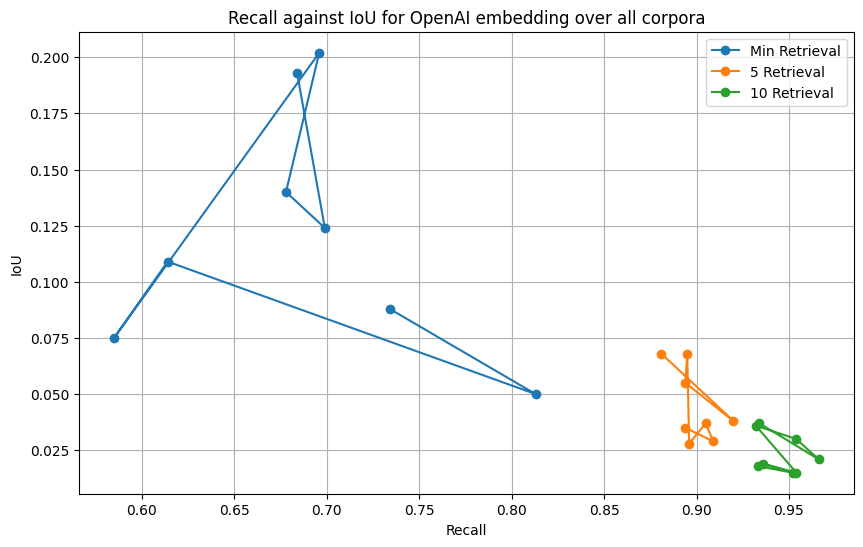

In [111]:
import matplotlib.pyplot as plt


# x and y sets as provided by the user
x_sets = [
    [0.734, 0.813, 0.614, 0.585, 0.696, 0.678, 0.699, 0.684],
    [0.894, 0.909, 0.905, 0.896, 0.895, 0.894, 0.920, 0.881],
    [0.933, 0.952, 0.936, 0.954, 0.932, 0.954, 0.966, 0.934]
]

y_sets = [
    [0.088, 0.050, 0.109, 0.075, 0.202, 0.140, 0.124, 0.193],
    [0.035, 0.029, 0.037, 0.028, 0.068, 0.055, 0.038, 0.068],
    [0.018, 0.015, 0.019, 0.015, 0.036, 0.030, 0.021, 0.037]
]

# Plotting the data with the requested labels and title
plt.figure(figsize=(10, 6))

labels = ["Min Retrieval", "5 Retrieval", "10 Retrieval"]
for i in range(len(x_sets)):
    plt.plot(x_sets[i], y_sets[i], marker='o', label=labels[i])

plt.xlabel('Recall')
plt.ylabel('IoU')
plt.title('Recall against IoU for OpenAI embedding over all corpora')
plt.legend()
plt.grid(True)
plt.show()


In [109]:
print(fake_corpus.find("_Her_"))

199


In [110]:
fake_corpus[:199]

'Mr. Bennet was so odd a mixture of quick parts, sarcastic humour,\nreserve, and caprice, that the experience of three-and-twenty years had\nbeen insufficient to make his wife understand his character. '

In [ ]:
What was the result of Mr. Bennet being so odd a mixture? ,"[{""content"": ""Mr. Bennet was so odd a mixture of quick parts, sarcastic humour, reserve, and caprice, that the experience of three-and-twenty years had been insufficient to make his wife understand his character."", ""start_index"": 0, ""end_index"": 199}]",./corpora/fake_corpora.txt

In [107]:
print(fake_corpus[0:199].replace("\n", " "))

Mr. Bennet was so odd a mixture of quick parts, sarcastic humour, reserve, and caprice, that the experience of three-and-twenty years had been insufficient to make his wife understand his character. 
